In [5]:
import pandas as pd
import numpy as np
import random as rd 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import sklearn as sk
import statsmodels.stats.api as sms 
from scipy import stats
import statsmodels.api as sm
import altair as alt
import plotly as px
import tensorflow as tf

In [90]:
df = pd.read_csv("D:/Nico@ThisHost/OneDrive/Documentos/NICOLAS/Data Science fundamentos/DATA SETS/regresion/realstateBSAS.csv")

In [91]:
# Convertir las fechas a datetime y convertir los errores a NaT
df["start_date"] = pd.to_datetime(df["start_date"], format="%Y-%m-%d", errors="coerce")
df["end_date"] = pd.to_datetime(df["end_date"], format="%Y-%m-%d", errors="coerce")

# Limpiando valores repetidos
df.drop_duplicates(inplace=True)

# Cambiandole el nombre a columnas para mejorar legible.
df.rename(columns={'l2': 'zona', 'l3': 'localidad'}, inplace=True)

In [92]:
# Limpio localidades residenciales sin baños.
df = df[~((df['property_type'].isin(['Departamento', 'Casa', 'Casa de campo', 'PH'])) & (df['bathrooms'].isna()))]

# Dropeo los registros cuya superficie total sea nula.
df = df.dropna(subset=['surface_total'])

# Dropeo los registros cuya superficie cubierta sea nula.
df = df.dropna(subset=['surface_covered'])

# Dropeo registros donde no se espesifica el tipo de propiedad.
df = df[df.property_type != "Otro"]

In [93]:
# Dropeo la variable currency ya que en la unica variable en la que se publica es en USD
df = df.drop(columns="currency")

In [94]:
# Precio metro cuadrado
df["pm2"] = df["price"] / df["surface_total"]

In [95]:
# Limipando valor atipico sin sentido en pm2.
df = df[df['pm2'] <= 25000]
df = df[df['pm2'] >= 400]
# Limipando valor atipico sin sentido en bathrooms.
df = df[df.bathrooms<8]
# Limipando valor atipico sin sentido en rooms.
df = df[df.rooms<15]
# Limipando valor atipico sin sentido en surface_total.
df = df[df.surface_total<2500]

EDA MACHINE LEARNING

In [41]:
# creando variables dummies para cada registro segun al barrio al que pertenece.
dummies = pd.get_dummies(df.localidad)
dummies = dummies.replace({True: 1, False: 0})

# Creando variables dummies para cada registro segun el tipo de propiedad que es.
dummies1= pd.get_dummies(df.property_type)
dummies1 = dummies1.replace({True: 1, False: 0})

In [96]:
# Creando df con valores numericos.
df_numeric = df.select_dtypes(include=["int64", "float64"])
df_numeric = df_numeric.drop(columns=["lon","lat","bedrooms","surface_covered"])

In [48]:
# uniendo las variables dummies al data frame
df2 = pd.concat([df_numeric,dummies],axis="columns")
df1 = pd.concat([df2,dummies1],axis="columns")

In [97]:
df3 = df_numeric.sample(frac=0.2, random_state=1)

In [98]:
# Prueba de distribucion, gracias por el regalo muy util
from scipy.stats import ks_2samp

columnas_numericas_datos = df1.select_dtypes(include="number").columns
columnas_numericas_muestra = df3.select_dtypes(include = "number").columns

for columna_datos, columna_muestra in zip(columnas_numericas_datos,columnas_numericas_muestra):
    stadistic, p_value = ks_2samp(df1[columna_datos], df3[columna_muestra])
    print(f"columna: {columna_datos}")
    print(f"Estadistico: {stadistic}") # cuanto mas chico mejor
    print(f"P-valor: {p_value}")    # El p valor tiene que ser mayor a 0,05 para pasar la prueba de que son distintos.
    print(f"------------------------------------")

columna: rooms
Estadistico: 0.0019805395391474523
P-valor: 0.9999992046128507
------------------------------------
columna: bathrooms
Estadistico: 0.0033932838003946086
P-valor: 0.9794536966984135
------------------------------------
columna: surface_total
Estadistico: 0.002892022981046183
P-valor: 0.9970088022704089
------------------------------------
columna: price
Estadistico: 0.002933282782812241
P-valor: 0.9963510777616057
------------------------------------
columna: pm2
Estadistico: 0.005772969715442056
P-valor: 0.5428191659355017
------------------------------------


In [99]:
# Creando variables X e y.
X = df3.drop("price",axis="columns")
y = df3.price

In [ ]:
# Creando grupo de entrenamiento.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
train_df = X_train.join(y_train)# Creando grupo de entrenamiento.

REDES NEURONALES

In [100]:
capa_entrada = tf.keras.layers.Dense(units=4, input_shape=[4])
capa_oculta = tf.keras.layers.Dense(units=4)
capa_salida = tf.keras.layers.Dense(units=1)

C:\Users\nicon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [101]:
modelo = tf.keras.Sequential([capa_entrada,capa_oculta,capa_salida])

In [102]:
modelo.compile(
    optimizer = tf.keras.optimizers.Adam(0.1),
    loss = "mean_squared_error"
)

In [103]:
print(" Inicio de entrenamiento...")
historial = modelo.fit(X, y, epochs=1000, verbose= False)
print("modelo entrenado")

 Inicio de entrenamiento...
modelo entrenado


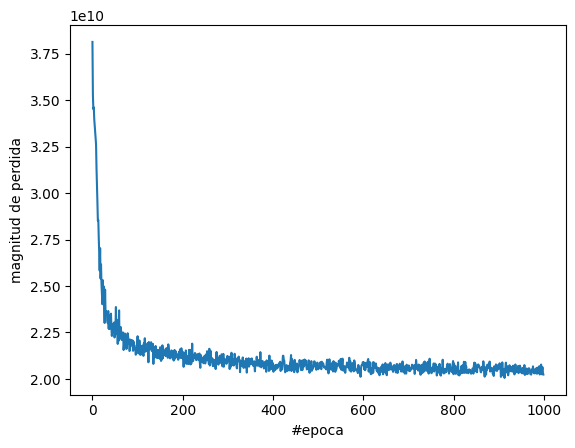

In [104]:
plt.xlabel("#epoca")
plt.ylabel("magnitud de perdida")
plt.plot(historial.history["loss"])
plt.show()

In [105]:
modelo.save("RealEstate.h5")

In [136]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def predict_price(rooms, bathrooms, surface_total, pm2, model):
    """
    Predicts the price of a property based on given features and a trained model,
    ensuring the minimum price is 12,000 and positive.

    Args:
        rooms (int): Number of rooms in the property.
        bathrooms (int): Number of bathrooms in the property.
        surface_total (float): Total surface area of the property.
        pm2 (float): Additional property-specific value (replace with your actual value).
        model (tf.keras.Model): Trained Keras model for price prediction.

    Returns:
        float: Predicted price of the property (minimum 12,000 and positive).
    """

    # Create a DataFrame with the provided features
    data = pd.DataFrame({
        "rooms": [rooms],
        "bathrooms": [bathrooms],
        "surface_total": [surface_total],
        "pm2": [pm2],
    })

    # Predict price using the trained model
    predicted_price = model.predict(data)[0][0]

    # Enforce minimum price of 12,000 and positive value
    predicted_price = max(12000, predicted_price)  # Ensures minimum of 12,000
    predicted_price = abs(predicted_price)  # Ensures positive value

    return predicted_price

In [139]:
from sklearn.preprocessing import StandardScaler

predicted_price = predict_price(2, 1, 20, 2000, modelo)
print("Predicted price for the property:", predicted_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted price for the property: 86864.96
